# Capstone Project: Price forecast for Trading

## Project Definition

### Project Overview

Stock prediction is a very studied topic. There are a lot of approaches in how to predict future prices to invest money. Here, we will studied a first approach to it.

### Problem Statement

In this project, we are going to try to forecast the Adj price for a range of days and tickers. This is a very ambitious project that not few people has tried. In this project, we will deep into some troubles we will face in the way to achieve it.
The strategy will be to get previous 365 days to predict the price of a range of days.

### Metrics 

W will use r square SVR:The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.



In [1]:

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from numpy import array
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import yfinance as yf
from matplotlib import pyplot
import datetime

## Analysis

### Data Exploration

The first part is to get the finance data of the tickers from yahoo finance API. The function returned us the Oen, Close, low, high, Volume and Adj Close. As we will try to predict Adj close, this will be the only column we will get. The format to get more than one ticker will be "AMZN AAPL".

In [16]:
def get_prices(comp):
    
    try: 
        fi_data = yf.download(comp,period="10y")

        if " " in comp:
            return fi_data['Adj Close']

        else:
            return pd.DataFrame({'Date':fi_data['Adj Close'].index, comp :fi_data['Adj Close'].values}).set_index("Date")
    except:
        print("Incorrect input ticker.Please, introduce the company tickers between spaces: 'AMZN GOOGL' ")
   
df=get_prices("AMZN GOOGL")
df

[*********************100%***********************]  2 of 2 completed


,AMZN,GOOGL
Date,,
2010-07-14,123.300003,245.915909
2010-07-15,122.059998,247.257263
2010-07-16,118.489998,230.035034
2010-07-19,119.940002,233.323318
2010-07-20,120.099998,241.036041
...,...,...
2020-07-08,3081.110107,1503.599976
2020-07-09,3182.629883,1518.660034
2020-07-10,3200.000000,1539.010010


### Data Visualization

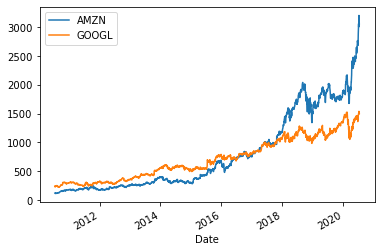

In [43]:
df.plot(kind="line")


## Methodology

In [47]:
# get values, tickers name and drop null values
def get_value_name(tickers,i):
    ticker_value = tickers[[tickers.columns[i]]].dropna()
    ticker_name = tickers.columns[i]
    return ticker_value, ticker_name 
get_value_name(df,0)

(                   AMZN
 Date                   
 2010-07-14   123.300003
 2010-07-15   122.059998
 2010-07-16   118.489998
 2010-07-19   119.940002
 2010-07-20   120.099998
 ...                 ...
 2020-07-08  3081.110107
 2020-07-09  3182.629883
 2020-07-10  3200.000000
 2020-07-13  3104.000000
 2020-07-14  3056.550049
 
 [2518 rows x 1 columns],
 'AMZN')

### Data Preprocessing

Drop null values and make arrays 

In [44]:
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array


Data transformation. To improve the algorithm, the data will be scaled.

In [46]:
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler 

### Implementation

Feature builder.This section creates feature set with lag number of predictors. Creating features using lagged data


In [48]:
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy
    df_copy = df.copy()
    

In [22]:
#train-test split for a user input ratio
def train_test_split(value, name, ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',nrow-split_row)
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row 

In [49]:
# fitting & Validating using SVR
def fit_svr(X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array):
    model_svr = SVR(kernel='rbf', tol=0.001, C=1.0, epsilon=0.1)#default
    model_svr.fit(X_train_tract1_array,y_train_tract1_array)
    y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)
    y_pred_test_tract1 = model_svr.predict(X_test_tract1_array)        
    print('r-square_SVR_Test: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2))
    return model_svr, y_pred_test_tract1  

### Refinement 

change SVR parameters to:<br>
kernel='rbf' <br>
gamma='auto'<br>
tol=0.001<br>
C=10.0<br>
epsilon=0.001<br>

In [50]:
# fitting & Validating using SVR
def fit_svr(X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array):
    model_svr = SVR(kernel='rbf', gamma='auto', tol=0.001, C=10.0, epsilon=0.001)
    model_svr.fit(X_train_tract1_array,y_train_tract1_array)
    y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)
    y_pred_test_tract1 = model_svr.predict(X_test_tract1_array)        
    print('r-square_SVR_Test: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2))
    return model_svr, y_pred_test_tract1   

## Results

In [28]:
# validation result  
def valid_result_svr(scaler, y_pred_test_tract1, ticker_value, split_row, lag):
    new_test_tract1 = ticker_value.iloc[split_row:]
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    y_pred_test_tract1_transformed = scaler.inverse_transform([y_pred_test_tract1])
    y_pred_test_tract1_transformed_reshaped = np.reshape(y_pred_test_tract1_transformed,(y_pred_test_tract1_transformed.shape[1],-1))
    test_tract1_pred['Forecast'] = np.array(y_pred_test_tract1_transformed_reshaped)
    return test_tract1_pred

In [29]:
# multi-step future forecast
def forecast_svr(X_test_tract1_array, days ,model_svr, lag, scaler):
    last_test_sample = X_test_tract1_array[-1]        
    X_last_test_sample = np.reshape(last_test_sample,(-1,X_test_tract1_array.shape[1]))        
    y_pred_last_sample = model_svr.predict(X_last_test_sample)                
    new_array = X_last_test_sample
    new_predict = y_pred_last_sample
    new_array = X_last_test_sample
    new_predict = y_pred_last_sample

    seven_days_svr=[]
    for i in range(0,days):               
            new_array = np.insert(new_array, 0, new_predict)                
            new_array = np.delete(new_array, -1)
            new_array_reshape = np.reshape(new_array, (-1,lag))                
            new_predict = model_svr.predict(new_array_reshape)
            temp_predict = scaler.inverse_transform([new_predict])
            seven_days_svr.append(temp_predict[0][0].round(2))
            
    return seven_days_svr 

In [30]:
def company_close_svr(tickers, lag,start_day, days):     
    
    seven_day_forecast_svr = pd.DataFrame(index=pd.date_range(start=start_day, periods=days+1, freq='D', closed='right')) 
    
    if len(tickers.columns)>1:
        fig, ax = plt.subplots(len(tickers.columns),1,figsize=(15,10),sharex=True)
    else:
        fig, axi = plt.subplots(len(tickers.columns),1,figsize=(15,10),sharex=True)
        ax=array([axi])
    for i in range(len(tickers.columns)):
        
        print(i)
        # preprocessing
        ticker_value, ticker_name = get_value_name(tickers,i)       
        train_tract1, test_tract1, split_row = train_test_split(ticker_value, ticker_name, 0.80)              
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)        
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)        
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                           test_tract1)

        # SVR modeling
        model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                                X_test_tract1_array, y_test_tract1_array)                       
        test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, ticker_value, split_row, lag)        
        seven_days_svr = forecast_svr(X_test_tract1_array, days, model_svr, lag, scaler)            
        seven_day_forecast_svr[ticker_name] = np.array(seven_days_svr)        
        
        # plot result
        

        #plt.figure(figsize=(20,5))
        ax[i].plot(test_tract1_pred)
        ax[i].plot(seven_day_forecast_svr[ticker_name], color='red', label='forecast') 
        ax[i].set_ylabel('Value ($)')
        ax[i].legend(loc='upper right')
        ax[i].set_title(ticker_name + ' Forecast')
        #plt.savefig("app/images/"+ticker_name+".png")
        #ax[i].show()    
    
    fig.savefig("app/images/plot.png")
    return(seven_day_forecast_svr)

### Model Evaluation and Validation

[*********************100%***********************]  2 of 2 completed
17
2020-07-13
0
AAPL total samples:  2518
Training samples:  2014
Testing samples:  504
r-square_SVR_Test:  0.92
1
AMZN total samples:  2518
Training samples:  2014
Testing samples:  504
r-square_SVR_Test:  0.95
Wall time: 4.64 s


,AAPL,AMZN
2020-07-14,369.41,3037.70
2020-07-15,364.76,3020.88
2020-07-16,360.42,3011.59
2020-07-17,355.64,2999.72
2020-07-18,352.55,2988.85
2020-07-19,349.20,2980.82
2020-07-20,345.18,2971.82
2020-07-21,341.94,2970.60
2020-07-22,338.49,2967.24
2020-07-23,334.02,2967.43


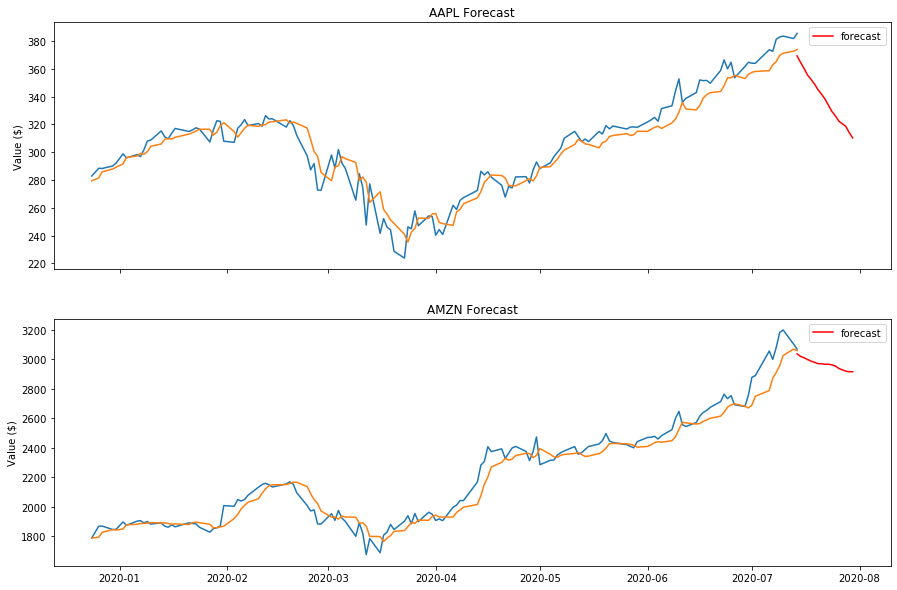

In [31]:
%%time
def Get_data(start_date, end_date,tickers):
    
    
    today=datetime.date.today()
    day=datetime.timedelta(days=1)
    yesterday=today-day
    start_date_dt=datetime.datetime.strptime(start_date, '%Y-%m-%d').date()

    end_date_dt=datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
    
    if start_date_dt<yesterday:
        return "First day must be (at least) today. Please, set other first day"

    if abs((start_date_dt-end_date_dt).days)>31:
        return "Cannot forecast more than 31 days. Please, reduce the number of days to forecast"
   
    if end_date_dt< start_date_dt:
        return "End day connot be before start day"  
    
    data=get_prices(tickers)
    
    start_date_dt=datetime.datetime.strptime(start_date, '%Y-%m-%d').date()-day
    print(str(abs((start_date_dt-end_date_dt).days)))
    print(str(start_date_dt))
    return company_close_svr(data, 365, start_date_dt,abs((start_date_dt-end_date_dt).days))
    
    
result=Get_data("2020-07-14",'2020-07-30',"AMZN AAPL")
result

### Justification

The results show a R square SVR of 0.92 and 0.95 for the example companies, and we can see the algorithm follows the trend of the stock evolution.
Also, it can be appreciate that for other points, the difference is quite significant.

## Conclusion

### Reflection

In this project, it have been made an approach of Stock forecasting using SVR. The results obtained have shown that our algorithm can follow trends, but it is not enough to invest money. 

Also, the results that forecast several days lead to a bad prediction. 

There are a lot of reasons of these results. Fincial markets have a lot of variables, and try to predict the future only with this data, seems quite difficult. Also, the increase of days to forescast increase the options of an relevant event to happen.

### Improvements

There are a lot of approach to improve this algorithm. One of them can be to use a deep learning network to check if it improves the results.

Also, It can be used more data. Maybe create some technicals indicator, as can be the MACD indicator, or use sentimental analysis of news or twitter.
<br>

